In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, ttest_ind
import matplotlib.font_manager as fm
import platform

plt.rcParams['font.family'] = 'Malgun Gothic'  # 또는 'NanumGothic', 'Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

USE_SPEARMAN = False  # True: 스피어만, False: 피어슨
USE_STANDARDIZATION = True  # Z-score 표준화 여부


# 데이터 불러오기
asthma_df = pd.read_excel('Asthma_top30_Sum_removed_outliers.xlsx', index_col=0, parse_dates=True)
dust_df = pd.read_excel("pm10_top30_fixed.xlsx", index_col=0, parse_dates=True)

# 날짜 동기화
common_index = dust_df.index.intersection(asthma_df.index)
dust_df = dust_df.loc[common_index].sort_index()
asthma_df = asthma_df.loc[common_index].sort_index()

# 숫자 변환 및 결측치 보간
dust_df = dust_df.apply(pd.to_numeric, errors='coerce').interpolate().dropna()
asthma_df = asthma_df.apply(pd.to_numeric, errors='coerce').loc[dust_df.index]

# 선택적으로 표준화
if USE_STANDARDIZATION:
    dust_df = (dust_df - dust_df.mean()) / dust_df.std()
    asthma_df = (asthma_df - asthma_df.mean()) / asthma_df.std()

# 대도시 / 비대도시 분할
dust_major = dust_df.iloc[:, 0:8]
dust_minor = dust_df.iloc[:, 8:]
asthma_major = asthma_df.iloc[:, 0:8]
asthma_minor = asthma_df.iloc[:, 8:]

# 상관계수 함수 (피어슨 or 스피어만 선택)
def get_corrs(df1, df2):
    corrs = []
    for i in range(df1.shape[1]):
        x, y = df1.iloc[:, i], df2.iloc[:, i]
        valid = x.notna() & y.notna()
        if valid.sum() >= 2:
            if USE_SPEARMAN:
                corr, _ = spearmanr(x[valid], y[valid])
            else:
                corr, _ = pearsonr(x[valid], y[valid])
            corrs.append(corr)
        else:
            corrs.append(np.nan)
    return corrs

# 상관계수 추출
major_corrs = get_corrs(dust_major, asthma_major)
minor_corrs = get_corrs(dust_minor, asthma_minor)

# 평균 비교 및 통계 검정
print(f"대도시 평균 상관계수: {np.nanmean(major_corrs):.3f}")
print(f"비대도시 평균 상관계수: {np.nanmean(minor_corrs):.3f}")
t_stat, p_val = ttest_ind(major_corrs, minor_corrs, nan_policy='omit')
print(f"독립표본 t-검정 결과: t = {t_stat:.3f}, p = {p_val:.4f}")

대도시 평균 상관계수: 0.519
비대도시 평균 상관계수: 0.496
독립표본 t-검정 결과: t = 0.594, p = 0.5566


C:\Users\dgdl1\AppData\Local\Temp\ipykernel_21892\3469216435.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="coolwarm")


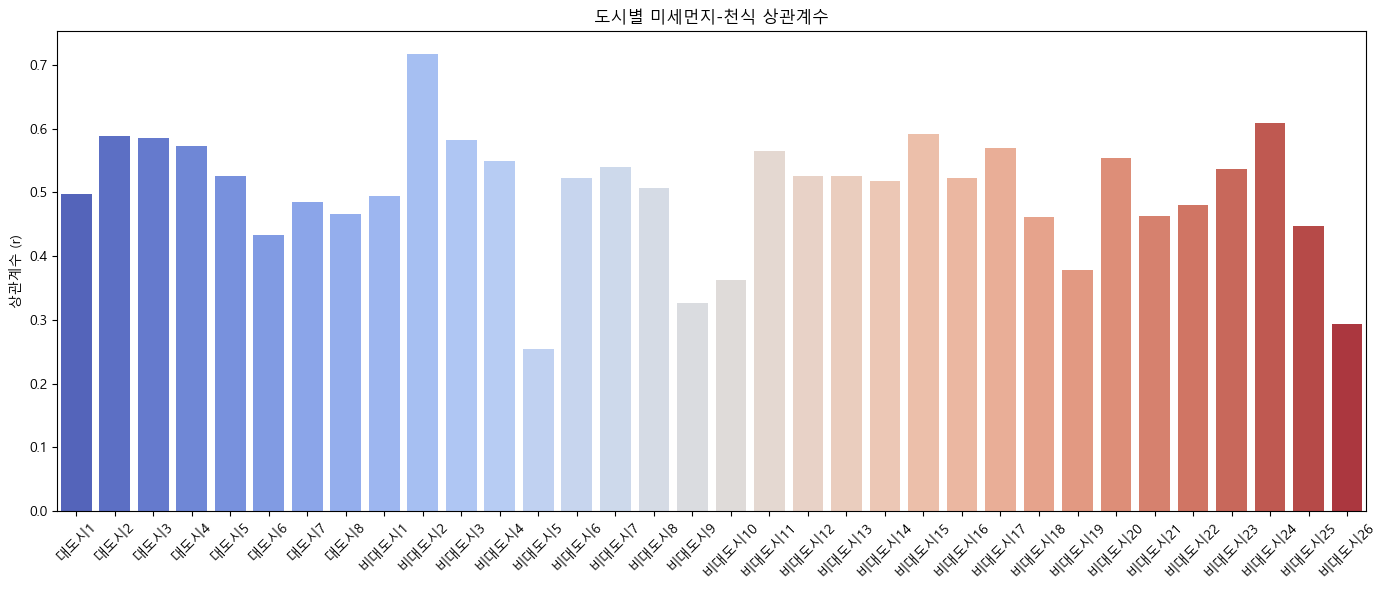

In [4]:
# 9. 시각화 1: 도시별 상관계수 막대그래프
plt.figure(figsize=(14, 6))
labels = [f"대도시{i+1}" for i in range(len(major_corrs))] + [f"비대도시{i+1}" for i in range(len(minor_corrs))]
values = major_corrs + minor_corrs
sns.barplot(x=labels, y=values, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("도시별 미세먼지-천식 상관계수")
plt.ylabel("상관계수 (r)")
plt.tight_layout()
plt.show()

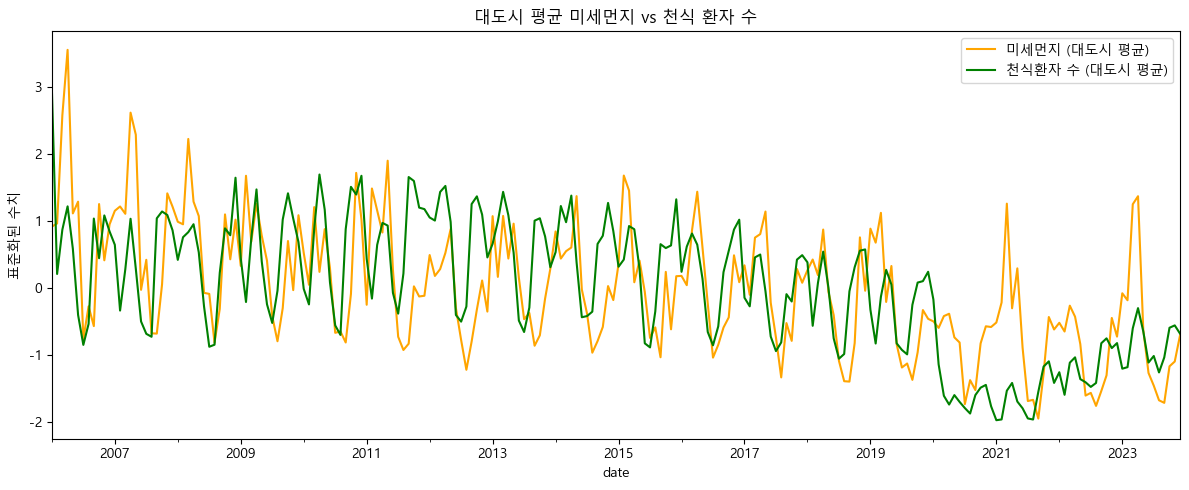

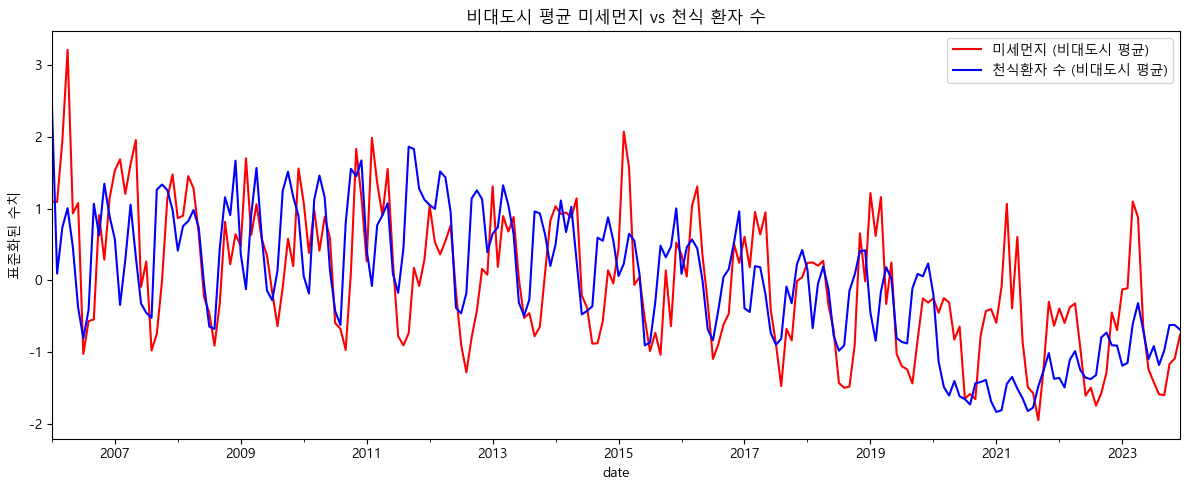

In [5]:
# 10. 시각화 2: 대도시 평균 미세먼지 vs 천식 시계열
plt.figure(figsize=(12, 5))
dust_major.mean(axis=1).plot(label="미세먼지 (대도시 평균)", color='orange')
asthma_major.mean(axis=1).plot(label="천식환자 수 (대도시 평균)", color='green')
plt.legend()
plt.title("대도시 평균 미세먼지 vs 천식 환자 수")
plt.ylabel("표준화된 수치" if USE_STANDARDIZATION else "수치")
plt.tight_layout()
plt.show()

# 11. 시각화: 비대도시 평균 미세먼지 vs 천식 환자 수
plt.figure(figsize=(12, 5))
dust_minor.mean(axis=1).plot(label="미세먼지 (비대도시 평균)", color='red')
asthma_minor.mean(axis=1).plot(label="천식환자 수 (비대도시 평균)", color='blue')
plt.legend()
plt.title("비대도시 평균 미세먼지 vs 천식 환자 수")
plt.ylabel("표준화된 수치" if USE_STANDARDIZATION else "수치")
plt.tight_layout()
plt.show()